In [1]:
import Nio
import Ngl
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# extract needed variables from CESM output (this is a minimal set) while concatenating or make
# a separate file - here is what I did:
#  ncrcat -v U,hyam,hybm,P0,PS 1903*.nc U.nc

In [11]:
ds = xr.open_dataset('UV.nc',decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 64, lev: 18, lon: 128, time: 12)
Coordinates:
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 -79.525604 -76.7369 ...
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 11.25 14.0625 16.875 ...
  * lev      (lev) float32 4.8093 13.0731 32.5591 63.947098 99.04321 ...
  * time     (time) float32 1126.0 1154.0 1185.0 1215.0 1246.0 1276.0 1307.0 ...
Data variables:
    P0       float32 ...
    hyam     (lev) float64 ...
    hybm     (lev) float64 ...
    PS       (time, lat, lon) float32 ...
    U        (time, lev, lat, lon) float32 ...
    V        (time, lev, lat, lon) float32 ...
Attributes:
    Conventions:               NCAR-CSM
    source:                    CCM
    case:                      cmip2014
    title:                     climo SSTs minus the cmip4 trend
    logname:                   naomi
    host:                      sunra
    history:                   Tue Apr 10 16:11:41 2018: ncrcat -v U,V,hyam,h...
    NCO:               

In [4]:
hbcofa = ds.hyam.values
hbcofb = ds.hybm.values
plevo = [1000,900,250]
psfc = ds.PS
intyp = 1
kxtrp = False  # True: extrapolate, # False: don't
p0 = ds.P0.values
np.shape(ds.U.values)

(12, 18, 64, 128)

In [16]:
u = Ngl.vinth2p(ds.U, hbcofa, hbcofb, plevo, psfc, intyp, p0, 1, kxtrp)

In [13]:
np.shape(u)

(12, 3, 64, 128)

In [7]:
ds_out = xr.Dataset({'lon': ('lon', ds.lon), 'lat': ('lat', ds.lat),\
                     'plev': ('plev', plevo), 'time': ('time',ds.time)})

In [14]:
ds_out['u'] = (['time','plev','lat','lon'],u)
ds_out.lon.attrs = ds.lon.attrs
ds_out.lat.attrs = ds.lat.attrs
ds_out.time.attrs = ds.time.attrs
ds_out.plev.attrs = [('units','mb')]
ds_out.u.attrs = [('units','m/s')]
ds_out.u.attrs = [('_FillValue',1e30)]

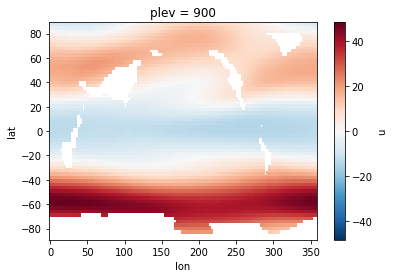

In [17]:
ds2 = ds_out.mean('time').sel(plev = 900)
ds2.where(ds2.u < 10000).u.plot()

In [19]:
ds_out.to_netcdf('u.nc')